In [ ]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from tqdm import tqdm

from PIL import Image

In [ ]:
Path = "../input/osic-pulmonary-fibrosis-progression"
df_train= pd.read_csv(f"{Path}/train.csv")
df_train.drop_duplicates(keep=False, inplace=True,subset=['Patient','Weeks'])
df_test= pd.read_csv(f"{Path}/test.csv")
Patient_list= df_train["Patient"].unique()

In [ ]:
def getDcms(patient,type):
    image_dir = f"{Path}/{type}/{patient}"
    fig=plt.figure(figsize=(10,10))
    image_list = os.listdir(image_dir)
    columns = int(np.sqrt(len(image_list)))
    rows = columns+1
    dcms=[]
    for i in tqdm(range(1, len(image_list) +1)):
        ds = pydicom.dcmread(image_dir + "/" + str(i) + ".dcm")
        dcms.append(ds.pixel_array)
        fig.add_subplot(rows,columns,i)
        plt.imshow(ds.pixel_array, cmap=plt.cm.bone)
    return dcms

list=getDcms(Patient_list[50],"train" )

In [ ]:
df_train

In [ ]:
def get_Weeks_Dcms(type):
    fig=plt.figure(figsize=(10,10))
    dcms=[]
    plist=[]
    wlist=[]
    for p in tqdm(Patient_list):
        image_dir = f"{Path}/{type}/{p}"
        week=df_train[df_train["Patient"]==p]["Weeks"]
        for w in week:
            try:
                ds = pydicom.dcmread(image_dir + "/" + str(w) + ".dcm")
                dcms.append(ds.pixel_array)
                plist.append(p)
                wlist.append(w)
            except:
                pass
    data = pd.DataFrame({"Patient":plist,"Weeks":wlist})        
    return dcms,data

In [ ]:
x_train,train_data=get_Weeks_Dcms("train")

In [ ]:
for i in range(0,len(x_train)):
    im = Image.fromarray(x_train[i])
    im = im.resize((128,128),resample=Image.NEAREST) 
    x_train[i] = np.array(im).reshape((128,128,1))
    #x_train[i] = np.array(im)
    
x_train=np.array(x_train)
train_data = pd.merge(train_data,df_train, how="left", on=['Patient',"Weeks"])

In [ ]:
train_data["Sex"]=train_data["Sex"].astype("category").cat.codes
train_data["SmokingStatus"]=train_data["SmokingStatus"].astype("category").cat.codes

<h3><font color=red>Min-Max Normalization </font> <h3>

In [ ]:
train_data["Weeks"]=(train_data['Weeks'] - train_data['Weeks'].min() ) / ( train_data['Weeks'].max() - train_data['Weeks'].min() )
train_data["Percent"]=(train_data['Percent'] - train_data['Percent'].min() ) / ( train_data['Age'].max() - train_data['Percent'].min() )
train_data["Age"]=(train_data['Age'] - train_data['Age'].min() ) / ( train_data['Age'].max() - train_data['Age'].min() )

In [ ]:
train_data

In [ ]:
y=train_data["FVC"].values
feature=train_data[['Weeks','Percent','Age','Sex',"SmokingStatus"]].values

 <h3><font color=red>Min-Max Normalization </font> <h3>

In [ ]:
x_min = np.min(x_train)
x_max = np.max(x_train)
xs = x_train - x_min / (x_max - x_min)

In [ ]:
y.shape,feature.shape,xs.shape,x_train.shape

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M

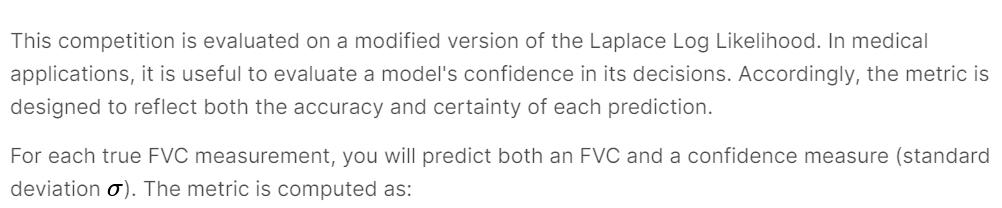

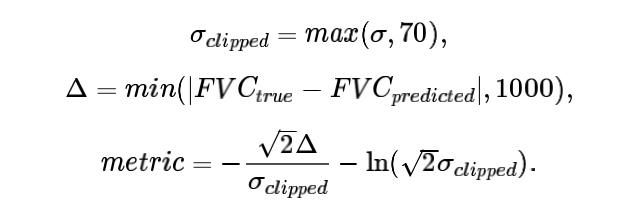

In [ ]:
C70, C10 = tf.constant(70, dtype='float32'), tf.constant(1000, dtype="float32")
#=============================#
def LaplaceLogLikelihood(y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    
    sigma_clip = tf.maximum(y_pred[:, 1], C70)
    
    delta = tf.minimum(tf.abs(y_true[:, 0] - y_pred[:, 0]), C10)
  
    sq2 = tf.sqrt( tf.dtypes.cast(2, dtype=tf.float32) )
    metric = (delta / sigma_clip)*sq2 + tf.math.log(sigma_clip* sq2)
    return K.mean(metric)
#=============================#
def regressionloss (y_true, y_pred):
    tf.dtypes.cast(y_true, tf.float32)
    tf.dtypes.cast(y_pred, tf.float32)
    spread = tf.abs( (y_true[:, 0] -  y_pred[:, 0])  / y_true[:, 0] )
    #spred = tf.square(y_true, y_pred[:, 0])
    return K.mean(spread)
#=============================#

def OSICloss(_lambda):
    def loss(y_true, y_pred):
        return _lambda * LaplaceLogLikelihood(y_true, y_pred) + (1 - _lambda)*regressionloss(y_true, y_pred)
    return loss
#=================

In [ ]:
def model_2D():
    ct = L.Input((128,128,1),name="Ctinput")  
    Patint = L.Input((5,), name="Patient" ) 
    x =L.Conv2D(64,(6,6),activation="relu",name="conv1")(ct)
    x =L.MaxPooling2D(pool_size=(3,3), name='pool1')(x)
    
    x = L.Conv2D(64,(6,6),activation="relu",name="conv2")(x)
    x = L.MaxPooling2D(pool_size=(3,3), name='pool2')(x)
    
    x = L.Conv2D(128,(6,6),activation="relu",name="conv3")(x)
    x = L.MaxPooling2D(pool_size=(2,2), name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(64, activation="relu", name="d1")(x)
    P = L.Dense(32, activation="relu", name="d2")(Patint)
    x = L.Concatenate(name="combine")([x, P])
    x = L.Dense(32, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
    
    return model

In [ ]:
net_2D = model_2D()
print(net_2D.summary())

In [ ]:
y.shape,feature.shape,xs.shape,x_train.shape

In [ ]:
y=y.astype("float32")

In [ ]:
net_2D.fit([x_train, feature], y, batch_size=50, epochs=100)

In [ ]:
def model_1D():
    ct = L.Input((128,128), name="input")
    Patint = L.Input((5,), name="Patient")
    x = L.Conv1D(50, 4, activation="relu", name="conv1")(ct)
    x = L.MaxPool1D(2, name='pool1')(x)
    
    
    x = L.Conv1D(50, 4, activation="relu", name="conv2")(x)
    x = L.MaxPool1D(2, name='pool2')(x)
    
  
    x = L.Conv1D(50, 4, activation="relu", name="conv3")(x)
    x = L.MaxPool1D(2, name='pool3')(x)
    
    x = L.Flatten(name="features")(x)
    x = L.Dense(50, activation="relu", name="d1")(x)
    l = L.Dense(10, activation="relu", name="d2")(Patint)
    x = L.Concatenate(name="combine")([x, l])
    x = L.Dense(50, activation="relu", name="d3")(x)
    preds = L.Dense(2, activation="relu", name="preds")(x)
    
    model = M.Model([ct, Patint], preds, name="CNN")
    model.compile(loss=OSICloss(0.5), optimizer="adam", metrics=[LaplaceLogLikelihood])
   
    return model

In [ ]:
net_1D = model_1D()
print(net_1D.summary())

In [ ]:
y.shape,feature.shape,xs.shape,x_train.shape

In [ ]:
y=y.astype("float32")

In [ ]:
net_1D.fit([xs, feature], y, batch_size=50, epochs=100) #, validation_split=0.1

In [ ]:
predict_2D=net_2D.predict([xs, feature], batch_size=100, verbose=1)

In [ ]:
predict_1D=net_1D.predict([xs, feature], batch_size=100, verbose=1)

In [ ]:
 pdata_2D = pd.DataFrame({"FVC":predict_2D[:,0],"CON":predict_2D[:,1]})    

In [ ]:
 pdata_1D = pd.DataFrame({"FVC":predict_1D[:,0],"CON":predict_1D[:,1]})   

In [ ]:
pdata_2D

In [ ]:
pdata_1D